# Extract and save individual patches for all images

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

We want to extract patches containing individual cells from seg.npy files which we get as a result of running CellPose.

In [2]:
def getImagesAndSegmentations(folderPath):
    """
    This function is a utility function to retrieve all images and segmentations from a folder.
    Input: folderPath - path to folder containing images and segmentations
    Output: images - list of images, segmentations - list of corresponding segmentations data i.e., seg.npy files
    """
    # retrieve all images and segmentations
    allFiles = os.listdir(folderPath)
    images = []
    segmentations = []
    for imgFile in allFiles:
        # if we have an actual image i.e., ends with .png
        if imgFile.endswith('.png'):
            correspondingSegFile = imgFile.split('.')[0] + '_seg.npy'
            imgFilePath = os.path.join(folderPath, imgFile)
            segFilePath = os.path.join(folderPath, correspondingSegFile)
            images.append(plt.imread(imgFilePath))
            segmentations.append(np.load(segFilePath, allow_pickle=True).item())
            
    return images, segmentations

In [3]:
def getCellPatches(image, segmentationData):
    """
    Input: image - image to extract cell patches from, segmentationData - segmentation data for the image
    Output: cellPatches - list of cell patches extracted from the image
    """
    cellPatches = []
    masksROI = segmentationData['masks']
    uniqueLabels = np.unique(masksROI)

    for l in uniqueLabels:
        if l == 0:
            # label for background so skip
            continue

        binMask = (masksROI == l).astype(np.uint8)
        contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        roiPatch = image[:, :, 0:3][y:y+h, x:x+w, :].copy()

        cellPatches.append(roiPatch)

    return cellPatches

def getCellPatchesWithNoBackgroundInfo(image, segmentationData):
    """
    Input: image - image to extract cell patches from, segmentationData - segmentation data for the image
    Output: cellPatches - list of cell patches extracted from the image with no background information
    """
    cellPatches = []
    masksROI = segmentationData['masks']
    uniqueLabels = np.unique(masksROI)

    for l in uniqueLabels:
        if l == 0:
            # label for background so skip
            continue

        binMask = (masksROI == l).astype(np.uint8)
        contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        roiPatch = image[:, :, 0:3][y:y+h, x:x+w, :].copy()

        # black out background
        roiPatch[binMask[y:y+h, x:x+w] == 0] = 0

        cellPatches.append(roiPatch)

    return cellPatches

def getCellPatchesBinMask(segmentationData):
    """
    Input: segmentationData - segmentation data for the image
    Output: binMasks - list of binary masks for each cell patch in the image
    """
    binMasks = []
    masksROI = segmentationData['masks']
    uniqueLabels = np.unique(masksROI)

    for l in uniqueLabels:
        if l == 0:
            # label for background so skip
            continue

        binMask = (masksROI == l).astype(np.uint8)

        binMasks.append(binMask)

    return binMasks

def getCellPatchesBinMask2(segmentationData):
    """
    Input: segmentationData - segmentation data for the image
    Output: binMasks - list of binary masks for each cell patch in the image (restricted in size by the bounding box of the cell patch)
    """
    binMasks = []
    masksROI = segmentationData['masks']
    uniqueLabels = np.unique(masksROI)

    for l in uniqueLabels:
        if l == 0:
            # label for background so skip
            continue

        binMask = (masksROI == l).astype(np.uint8)
        contours, _ = cv2.findContours(binMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        binMask = binMask[y:y+h, x:x+w]

        binMasks.append(binMask)

    return binMasks

In [4]:
allImages, allSegmentations = getImagesAndSegmentations("imagesAndSegmentations")

In [5]:
len(allImages), len(allSegmentations)

(40, 40)

Store all patches.

In [6]:
def getCellPatchesForAllImages(allImages, allSegmentations):
    """
    Input: allImages - list of all images, allSegmentations - list of all segmentation data
    Output: allPatches - list of all cell patches
    """
    allPatches = []
    for i in range(len(allImages)):
        cellPatches = getCellPatches(allImages[i], allSegmentations[i])
        allPatches.extend(cellPatches)

    return allPatches

In [7]:
allPatches = getCellPatchesForAllImages(allImages, allSegmentations)

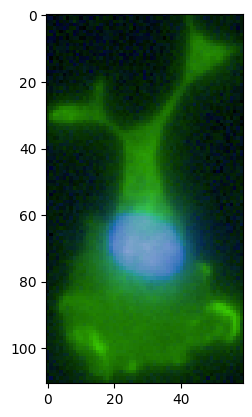

In [13]:
plt.imshow(allPatches[2])

(Optional as it appears to better to store images with their contextual background information) Store all patches with no background information. 

In [14]:
def getCellPatchesForAllImagesWithNoBackgroundInfo(allImages, allSegmentations):
    """
    Input: allImages - list of all images, allSegmentations - list of all segmentation data
    Output: allPatches - list of all cell patches
    """
    allPatchesWithNoBackgroundInfo = []
    for i in range(len(allImages)):
        cellPatches = getCellPatchesWithNoBackgroundInfo(allImages[i], allSegmentations[i])
        allPatchesWithNoBackgroundInfo.extend(cellPatches)

    return allPatchesWithNoBackgroundInfo

In [15]:
allPatchesWithNoBackgroundInfo = getCellPatchesForAllImagesWithNoBackgroundInfo(allImages, allSegmentations)

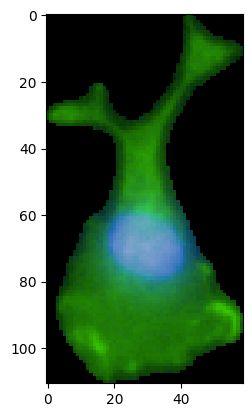

In [16]:
plt.imshow(allPatchesWithNoBackgroundInfo[2])

Store all binary masks.

In [17]:
def getCellPatchesBinMaskForAllImages(allSegmentations):
    """
    Input: allSegmentations - list of all segmentation data
    Output: allBinMasks - list of all binary masks for each cell patch
    """
    allBinMasks = []
    for i in range(len(allSegmentations)):
        binMasks = getCellPatchesBinMask(allSegmentations[i])
        allBinMasks.extend(binMasks)

    return allBinMasks

In [18]:
allBinMasks = getCellPatchesBinMaskForAllImages(allSegmentations)

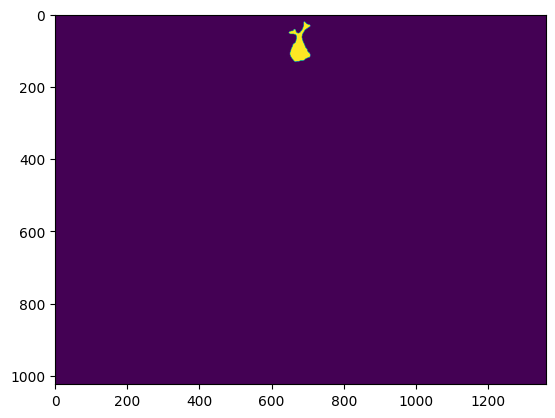

In [19]:
plt.imshow(allBinMasks[2])

Store all binary masks2.

In [20]:
def getCellPatchesBinMask2ForAllImages(allSegmentations):
    """
    Input: allSegmentations - list of all segmentation data
    Output: allBinMasks - list of all binary masks for each cell patch (restricted in size by the bounding box of the cell patch)
    """
    allBinMasks = []
    for i in range(len(allSegmentations)):
        binMasks = getCellPatchesBinMask2(allSegmentations[i])
        allBinMasks.extend(binMasks)

    return allBinMasks

In [21]:
allBinMasks2 = getCellPatchesBinMask2ForAllImages(allSegmentations)

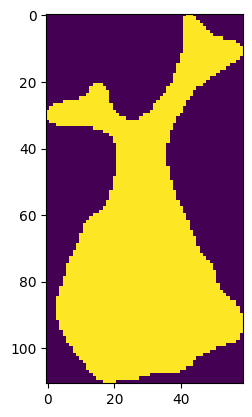

In [22]:
plt.imshow(allBinMasks2[2])

We save all the patches and masks in a folder.

In [23]:
def saveAllPatches(folderName, rgbAllPatches):
    """
    Input: folderName - name of folder to save patches to, rgbAllPatches - list of all cell patches
    Output: None
    """
    if os.path.exists(folderName):
        shutil.rmtree(folderName)
    os.mkdir(folderName)
    for i in range(len(rgbAllPatches)):
        # scale image from 0-1 to 0-255
        scaledImage = (rgbAllPatches[i] * 255).astype(np.uint8)
        # convert from 0-255 to BGR
        bgrImage = cv2.cvtColor(scaledImage, cv2.COLOR_RGB2BGR)
        # save image
        imgPath = os.path.join(folderName, str(i) + '.png')
        cv2.imwrite(imgPath, bgrImage)

In [24]:
saveAllPatches("allCellPatches", allPatches)

In [25]:
saveAllPatches("allCellPatchesWithNoBackgroundInfo", allPatchesWithNoBackgroundInfo)

In [26]:
def saveAllBinMasks(folderName, allBinMasksGrayscale):
    """
    Input: folderName - name of folder to save binary masks to, allBinMasksGrayscale - list of all binary masks
    Output: None
    """
    if os.path.exists(folderName):
        shutil.rmtree(folderName)
    os.mkdir(folderName)
    for i in range(len(allBinMasksGrayscale)):
        # scale image from 0-1 to 0-255 (if needed)
        scaledImage = (allBinMasksGrayscale[i] * 255).astype(np.uint8) if np.max(allBinMasksGrayscale[i]) <= 1 else allBinMasksGrayscale[i].astype(np.uint8)
        # save image
        imgPath = os.path.join(folderName, str(i) + '_mask.png')
        cv2.imwrite(imgPath, scaledImage)

In [27]:
saveAllBinMasks("allCellPatchesBinMasks", allBinMasks)

In [29]:
saveAllBinMasks("allCellPatchesBinMasks2", allBinMasks2)